# Model Exploration
Anna Mowat

Anna's Note for Averine (Nov 16, 2024):

I've been recording Accuracy and Loss in the box below. I misspoke in Slack, I still haven't done two tests: Bio-electric and Physical Activity. 

Physical Activity requires some infilling. I was going to just create one column out of PAQ_A-PAQ_A_Total and PAQ_A-PAQ_C_Total. 

For Bio-electric, I just haven't had a chance to work through all the variables to figure out which ones to keep for that model.

Fitness Test | Multiclass or Binary | Accuracy | Loss 
-|-|-|-
 Children's Global Assessment Scale | Multi | 0.567 | 1.229
 Children's Global Assessment Scale | Binary | 0.567 | 0.827
 Physical Measures | Multi | 0.437 | 1.102 
 Physical Measures | Binary | 0.564 | 0.732 
 Fitness Endurance | Multi | 0.716 | 0.838 
 Fitness Endurance | Binary | 0.564 | 0.732
 FitnessGram | Multi | 0.339 | 1.489 
 FitnessGram | Binary | 0.405 | 0.902
 Bio-electric Impedance | Multi |  |  
 Bio-electric Impedance | Binary |  | 
 Physical Activity | Multi |  |  
 Physical Activity | Binary |  | 
 Internet Addiction | Multi | 0.430 | 0.971
 Internet Addiction | Binary | 0.404 | 0.902
 Sleep Disturbance Scale | Multi | 0.572 | 1.069
 Sleep Disturbance Scale | Binary | 0.572 | 0.839

## Data Preprocessing

In [549]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [550]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [551]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))


In [552]:
data_dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [553]:
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define Different Tests

In [554]:
cols = list(data.columns)
col_groups = {}

In [555]:
season_dict = {'Winter':0,'Spring':1,'Summer':2,'Fall':3}
for col in cols:
    if 'Season' in col:
        data[col] = data[col].map(season_dict)


In [556]:
# demographic features
col_groups["Basic_Demos"] = [col for col in cols if 'Basic_Demos' in col]
col_groups["Basic_Demos"].append("sii")
print("Demographics:",col_groups["Basic_Demos"])

# Children's Global Assessment Scale
col_groups["CGAS"] = [col for col in cols if 'CGAS' in col]
col_groups["CGAS"].append("sii")
print("\nChildren's Global Assessment Scale:",col_groups["CGAS"])

# physical measures
col_groups["Physical"] = [col for col in cols if 'Physical' in col]
col_groups["Physical"].append("sii")
print("\nPhysical Measures:",col_groups["Physical"])

# FitnessGram vitals and treadmill
col_groups["Fitness_Endurance"] = [col for col in cols if 'Fitness_Endurance' in col]
col_groups["Fitness_Endurance"].append("sii")
print("\nFitnessGram Vitals and Treadmill:",col_groups["Fitness_Endurance"])

# FitnessGram Child
col_groups["FGC"] = [col for col in cols if 'FGC' in col]
col_groups["FGC"].append("sii")
print("\nFitnessGram Child:",col_groups["FGC"])

# bio-electric impedance analysis
col_groups["BIA"] = [col for col in cols if 'BIA' in col]
col_groups["BIA"].append("sii")
print("\nBio-electric Impedance Analysis:",col_groups["BIA"])

# physical activity questionnaire
col_groups["PAQ"] = [col for col in cols if 'PAQ' in col]
col_groups["PAQ"].append("sii")
print("\nPhysical Activity Questionnaire:",col_groups["PAQ"])

# parent-child internet addiction test
col_groups["PCIAT"] = [col for col in cols if 'PCIAT' in col]
col_groups["PCIAT"].append("sii")
print("\nParent-Child Internet Addiciton Test:",col_groups["PCIAT"])

# sleep disturbance scale
col_groups["SDS"] = [col for col in cols if 'SDS' in col]
#col_groups["SDS"].append("sii")
print("\nSleep Disturbance Scale:",col_groups["SDS"])

# internet use
col_groups["PreInt"] = [col for col in cols if 'PreInt' in col]
col_groups["SDS"].append("sii")
print("\nInternet Use:",col_groups["PreInt"])

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'sii']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score', 'sii']

Physical Measures: ['Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'sii']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'sii']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'sii']

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI

# Split into train, test, val

### Functions

In [557]:
def preprocess_data_part2(inputs, labels, splits):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Arrays
    labels (np.ndarray): Labels of shape (N,)   
    splits (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train  of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    shuffle = np.random.permutation(np.arange(inputs.shape[0]))
    inputs, labels = inputs[shuffle], labels[shuffle]
    
    # create random splits
    splits = np.multiply(len(inputs), split).astype(int)
    X_train, X_val, X_test = np.split(inputs, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle).numpy() # transform X back to numpy array instead of tensor
    y_train = tf.gather(y_train, shuffle).numpy() # transform y back to numpy array instead of tensor


    return X_train, y_train, X_val, y_val, X_test, y_test

In [558]:
def build_model(model = "multiclass", learning_rate = 0.01, X_train = X_train, y_train = y_train):
    if model == "multiclass":
        tf.keras.backend.clear_session()
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(
            units=4,                     # output dim
            input_shape=[X_train.shape[1]],             # input dim
            use_bias=False,              # we included the bias in X
            activation='softmax',        # apply a sigmoid to the output
            kernel_initializer=tf.ones_initializer,  # initialize params to 1
        ))
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    if model == "binary":
        tf.keras.backend.clear_session()
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(
            units=2,                     # output dim
            input_shape=[X_train.shape[1]],             # input dim
            use_bias=False,              # we included the bias in X
            activation='sigmoid',        # apply a sigmoid to the output
            kernel_initializer=tf.ones_initializer,  # initialize params to 1
        ))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

    return model

## Children's Global Assessment Scale

In [559]:
col_groups["CGAS"]

['CGAS-Season', 'CGAS-CGAS_Score', 'sii']

In [560]:
data_dict[data_dict["Instrument"].str.contains("Children's Global")]

,Instrument,Field,Description,Type,Values,Value Labels
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN


Running a pair plot to check for any multicollinearity

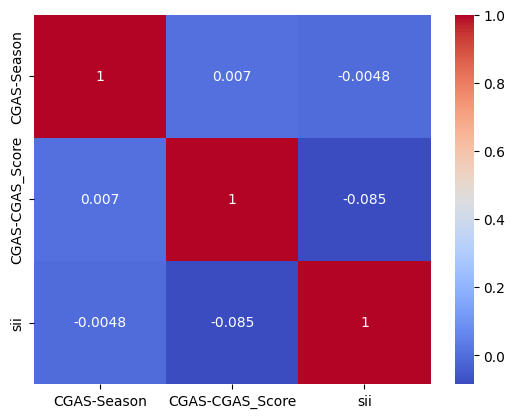

In [561]:
# Assuming you have a dataframe 'df' with your features
correlation_matrix = data[col_groups["CGAS"]].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [562]:
# Drop rows where scores are empty 
# Dropping all because sometimes sii is empty too
CGAS_df = data[col_groups["CGAS"]].dropna()

### Multiclass Logistic Regression

In [563]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    CGAS_df.drop('sii', axis=1).to_numpy(),
    CGAS_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1405, 2)
y_train shape (1405, 1)
X_val shape (468, 2)
y_val shape (468, 1)
X_test shape (469, 2)
y_test shape (469, 1)


In [564]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.0874367952346802
W:
 [[1.0184928  1.0320693 ]
 [1.0384785  0.993806  ]
 [0.89720124 1.005136  ]
 [1.0757844  0.95720565]]


In [565]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step
The accuracy is:0.5671641791044776
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 1.2254


1.2298269271850586

### Logistic Regression

In [566]:
# Make sii a logistic regression to either refer or not refer a patient
CGAS_df['sii'] = CGAS_df['sii'].replace(2.0, 1.0)
CGAS_df['sii'] = CGAS_df['sii'].replace(3.0, 1.0)

In [567]:
# Checking the replace worked
CGAS_df["sii"].value_counts()

sii
0.0    1359
1.0     983
Name: count, dtype: int64

In [568]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    CGAS_df.drop('sii', axis=1).to_numpy(),
    CGAS_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1405, 2)
y_train shape (1405, 1)
X_val shape (468, 2)
y_val shape (468, 1)
X_test shape (469, 2)
y_test shape (469, 1)


In [569]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=2,                     # output dim
    input_shape=[X_train.shape[1]],             # input dim
    use_bias=False,              # we included the bias in X
    activation='sigmoid',        # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [570]:
# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

 1/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7376506328582764
W:
 [[1.0074686 1.0106949]
 [0.9925619 0.9893334]]


In [571]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is: {accuracy}")
model.evaluate(x=X_test, y=y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


The accuracy is: 0.5671641791044776
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.8202


0.827095091342926

## Physical Measures

In [572]:
col_groups["Physical"]

['Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'sii']

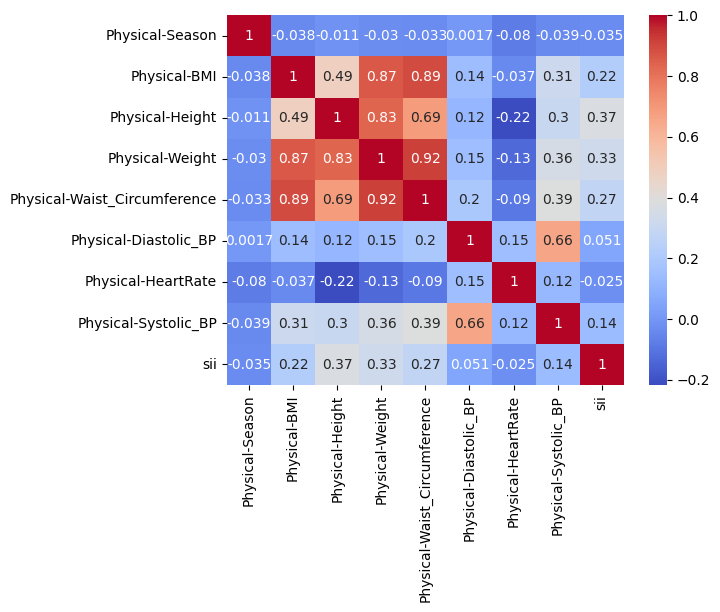

In [573]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = data[col_groups["Physical"]].corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Droping height and weight as they correlate strongly with BMI. Diastolic and systolic correlate but they measure important different variables so keeping both.

In [574]:
physical_df = data[col_groups["Physical"]]
physical_df.drop(['Physical-Height', 'Physical-Weight'], axis=1, inplace=True)

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3321936381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_df.drop(['Physical-Height', 'Physical-Weight'], axis=1, inplace=True)


In [575]:
# Dropping all rows with empty values
physical_df = physical_df.dropna()

### Multiclass Regression

In [576]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [577]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.359559178352356
W:
 [[1.0387322  0.85978633 0.9879425  1.0078522  1.0264398  1.021918  ]
 [0.96222407 0.99400026 1.07475    1.0368915  0.9949265  0.98309785]
 [0.8090837  1.1067122  0.94418705 0.9950395  0.991311   1.0103412 ]
 [1.7277503  1.3176514  1.0412221  0.8666163  0.96644294 0.98462546]]


In [578]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The accuracy is:0.43730194658216387
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 1.1686


1.1024730205535889

### Binary Regression

In [579]:
# Make sii a logistic regression to either refer or not refer a patient
physical_df['sii'] = physical_df['sii'].replace(2.0, 1.0)
physical_df['sii'] = physical_df['sii'].replace(3.0, 1.0)

In [580]:
# Checking the replace worked
physical_df["sii"].value_counts()

sii
0.0    303
1.0    161
Name: count, dtype: int64

In [581]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [582]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.886015772819519
W:
 [[1.0923564  0.9107206  0.96374047 0.9950849  1.0165806  1.0134614 ]
 [0.9076421  1.089279   1.0362593  1.004916   0.9834192  0.9865397 ]]


In [583]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


The accuracy is:0.5638297872340425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.7291


0.7318077683448792

## Fitness Endurance

In [584]:
fitness_endurance_df = data[col_groups["Fitness_Endurance"]]

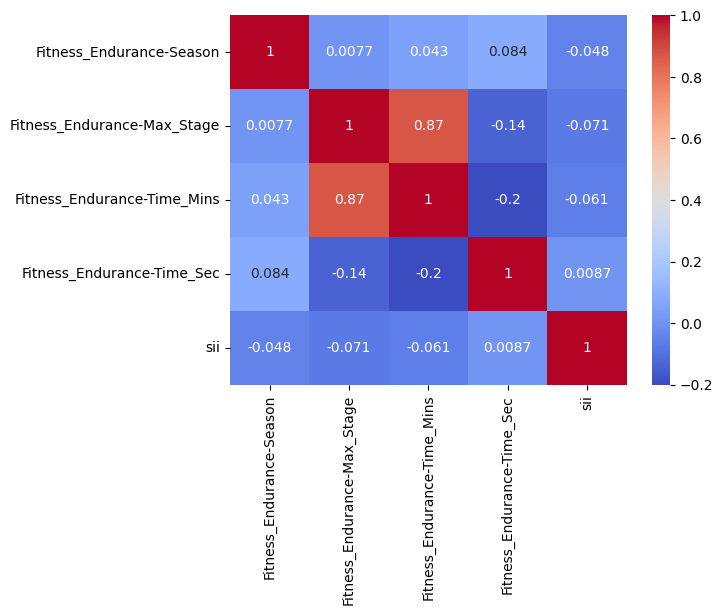

In [585]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = fitness_endurance_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Don't see any concerning correlation between dependant variables.

In [586]:
# Dropping all rows with empty values
fitness_endurance_df = fitness_endurance_df.dropna()

### Multiclass Regression

In [587]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fitness_endurance_df.drop('sii', axis=1).to_numpy(),
    fitness_endurance_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (436, 4)
y_train shape (436, 1)
X_val shape (145, 4)
y_val shape (145, 1)
X_test shape (146, 4)
y_test shape (146, 1)


In [588]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 0.9719595909118652
W:
 [[1.0664299  1.2414589  0.9549561  1.0367099 ]
 [1.0104591  0.9616017  1.0454117  1.045084  ]
 [1.0491434  0.7278645  1.1203306  1.0082834 ]
 [0.37109235 0.70167875 0.92406625 0.90240765]]


In [589]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


The accuracy is:0.7156595984237193
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.8293


0.8376806378364563

### Binary

In [590]:
# Make sii a logistic regression to either refer or not refer a patient
fitness_endurance_df['sii'] = fitness_endurance_df['sii'].replace(2.0, 1.0)
fitness_endurance_df['sii'] = fitness_endurance_df['sii'].replace(3.0, 1.0)

In [591]:
# Checking the replace worked
fitness_endurance_df["sii"].value_counts()

sii
0.0    480
1.0    247
Name: count, dtype: int64

In [592]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    physical_df.drop('sii', axis=1).to_numpy(),
    physical_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (278, 6)
y_train shape (278, 1)
X_val shape (92, 6)
y_val shape (92, 1)
X_test shape (94, 6)
y_test shape (94, 1)


In [593]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.886015772819519
W:
 [[1.0923564  0.9107206  0.96374047 0.9950849  1.0165806  1.0134614 ]
 [0.9076421  1.089279   1.0362593  1.004916   0.9834192  0.9865397 ]]


In [594]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


The accuracy is:0.5638297872340425
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.7291


0.7318077683448792

## FitnessGram Child

In [595]:
fg_df = data[col_groups["FGC"]]

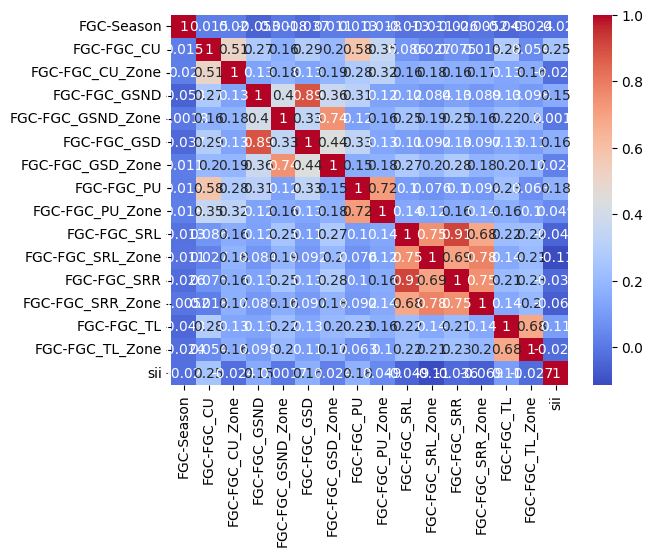

In [596]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = fg_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Looks like all the zones are just binned version of their equivalent fitness gram measurements.

In [597]:
fg_df.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',"FGC-FGC_GSD_Zone",
            "FGC-FGC_PU_Zone","FGC-FGC_SRL_Zone","FGC-FGC_SRR_Zone",
            "FGC-FGC_TL_Zone"], axis=1, inplace=True)

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3364836189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fg_df.drop(['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',"FGC-FGC_GSD_Zone",


In [598]:
# Dropping all rows with empty values
fg_df = fg_df.dropna()

### Multiclass

In [599]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [600]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.3188161849975586
W:
 [[1.0649445  0.9957121  1.0039076  0.98411566 0.98723245 1.0615492
  0.9635609  1.0543606 ]
 [1.1099508  1.0305173  1.0018984  1.0114157  1.0093622  1.0874416
  0.93285537 1.0758038 ]
 [0.84987354 1.0045167  1.0086457  1.0076814  1.0122164  0.9294162
  1.0896399  0.97743493]
 [0.76838326 1.0114008  1.0038847  1.040686   1.0469213  0.781785
  1.2564981  0.77093226]]


In [601]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


The accuracy is:0.3394700791874102
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 1.4347


1.4891475439071655

### Binary

In [602]:
# Make sii a logistic regression to either refer or not refer a patient
fg_df['sii'] = fg_df['sii'].replace(2.0, 1.0)
fg_df['sii'] = fg_df['sii'].replace(3.0, 1.0)

In [603]:
# Checking the replace worked
fg_df["sii"].value_counts()

sii
1.0    497
0.0    364
Name: count, dtype: int64

In [604]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [605]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7593514919281006
W:
 [[1.0034976  0.98593074 0.99563515 0.98009896 0.9887276  1.0198101
  0.96487176 1.0005668 ]
 [0.99650496 1.0140725  1.0043653  1.0199004  1.0112742  0.9801899
  1.0351261  0.999435  ]]


In [606]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step


The accuracy is:0.4046242774566474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.8735


0.9018865823745728

## Bio-electric

In [607]:
bia_df = data[col_groups["BIA"]]

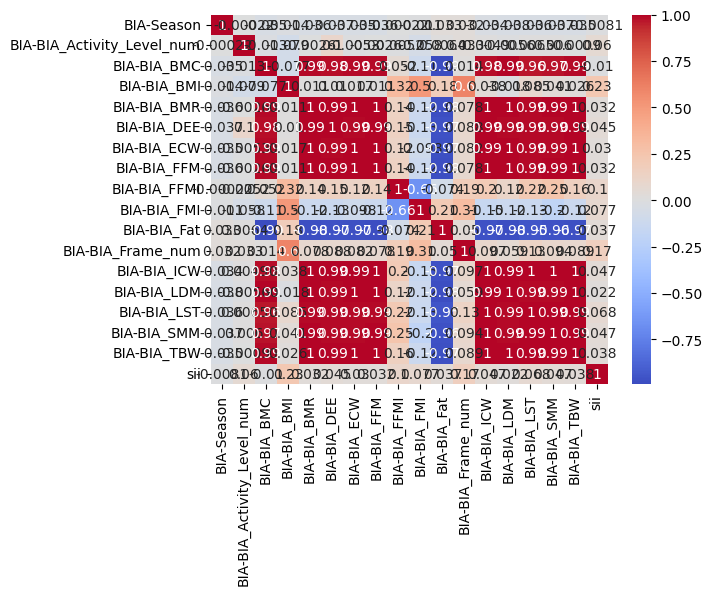

In [608]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = bia_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [609]:
data_dict[data_dict["Field"].str.contains("BIA")]

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


## Physical Activity

In [610]:
paq_df = data[col_groups["PAQ"]]

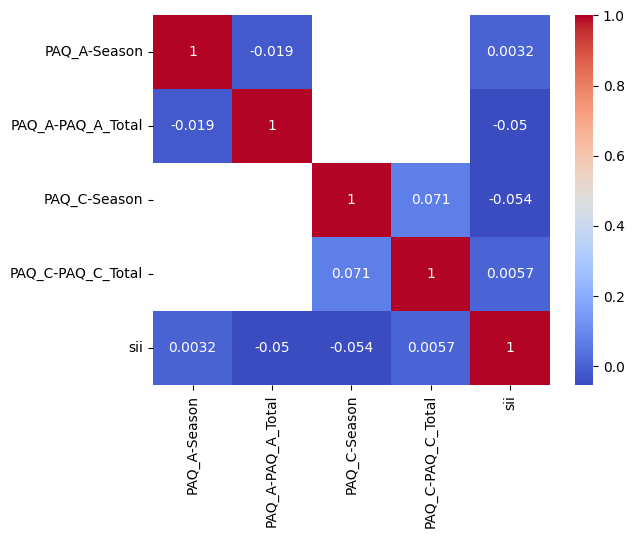

In [611]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = paq_df.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [612]:
paq_df

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,sii
0,NaN,NaN,NaN,NaN,2.0
1,NaN,NaN,3.0,2.340,0.0
2,NaN,NaN,2.0,2.170,0.0
3,NaN,NaN,0.0,2.451,1.0
4,2.0,1.04,NaN,NaN,NaN
...,...,...,...,...,...
3955,NaN,NaN,0.0,3.260,1.0
3956,NaN,NaN,0.0,2.340,NaN
3957,NaN,NaN,0.0,2.729,1.0
3958,NaN,NaN,1.0,3.300,0.0


In [613]:
# Dropping all rows with empty values
paq_df = paq_df.dropna()

In [614]:
paq_df

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,sii
3331,2.0,2.27,1.0,2.32,1.0


In [615]:
data_dict[data_dict["Field"].str.contains("PAQ")]

,Instrument,Field,Description,Type,Values,Value Labels
50,Physical Activity Questionnaire (Adolescents),PAQ_A-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
51,Physical Activity Questionnaire (Adolescents),PAQ_A-PAQ_A_Total,Activity Summary Score (Adolescents),float,NaN,NaN
52,Physical Activity Questionnaire (Children),PAQ_C-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
53,Physical Activity Questionnaire (Children),PAQ_C-PAQ_C_Total,Activity Summary Score (Children),float,NaN,NaN


### Multiclass

In [616]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    paq_df.drop('sii', axis=1).to_numpy(),
    paq_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (0, 4)
y_train shape (0, 1)
X_val shape (0, 4)
y_val shape (0, 1)
X_test shape (1, 4)
y_test shape (1, 1)


## Internet Addiction

In [617]:
pciat = data[col_groups["PCIAT"]]

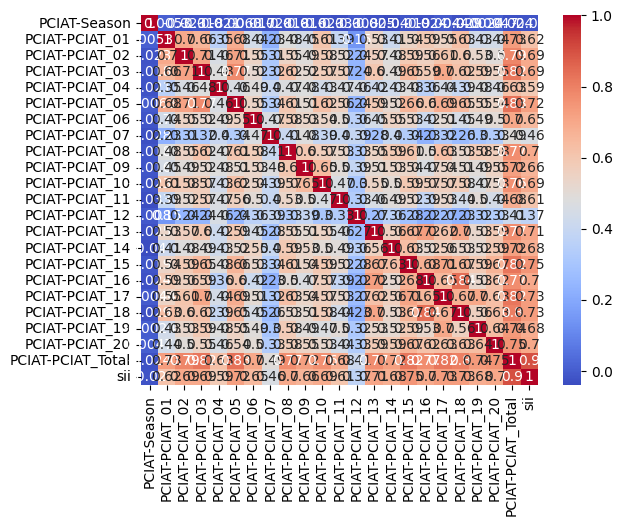

In [618]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = pciat.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Dropping PCIAT Total since that's the sum of all the PCIAT questions

In [619]:
pciat.drop(['PCIAT-PCIAT_Total'], axis=1, inplace=True)

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3779530865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pciat.drop(['PCIAT-PCIAT_Total'], axis=1, inplace=True)


In [620]:
# Dropping all rows with empty values
pciat = pciat.dropna()

### Multiclass

In [621]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    pciat.drop('sii', axis=1).to_numpy(),
    pciat[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1602, 21)
y_train shape (1602, 1)
X_val shape (534, 21)
y_val shape (534, 1)
X_test shape (535, 21)
y_test shape (535, 1)


In [622]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.0213873386383057
W:
 [[ 1.9195477   1.4169095   0.9239212   1.7800341   0.50049114  1.064159
   0.7670871   0.8904111   0.5815955   0.7924638   0.6605463   1.1368132
   1.4826124   0.9078215   0.83717555  0.7206181   0.92412317  1.034521
   0.8732474   0.6238959   0.6898347 ]
 [ 0.9323412   0.99757177  1.1128551   1.2041734   0.7314455   1.2836285
   0.7676551   0.889097    0.8277505   0.98874986  0.7472521   1.1149255
   1.3156068   1.0269043   0.9315634   0.9750643   0.99688226  1.1251032
   0.9959852   0.81216973  0.8080144 ]
 [ 0.27294743  0.8449079   1.1037741   0.543706    1.2317476   1.065563
   0.9831643   0.9108749   1.0770826   1.0586079   1.2115455   1.009165
   0.7814402   1.1445795   1.040933    1.1318377   1.1501765   1.1832964
   1.2248702   1.1518459   0.90983295]
 [-0.43873426  0.45055243  0.78577787 -0.2918349

In [623]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step
The accuracy is:0.4300707485369901
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 1.0033


0.9710525870323181

### Binary

In [624]:
# Make sii a logistic regression to either refer or not refer a patient
pciat['sii'] = pciat['sii'].replace(2.0, 1.0)
pciat['sii'] = pciat['sii'].replace(3.0, 1.0)

In [625]:
# Checking the replace worked
pciat["sii"].value_counts()

sii
0.0    1568
1.0    1103
Name: count, dtype: int64

In [626]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    fg_df.drop('sii', axis=1).to_numpy(),
    fg_df[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (516, 8)
y_train shape (516, 1)
X_val shape (172, 8)
y_val shape (172, 1)
X_test shape (173, 8)
y_test shape (173, 1)


In [627]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7593514919281006
W:
 [[1.0034976  0.98593074 0.99563515 0.98009896 0.9887276  1.0198101
  0.96487176 1.0005668 ]
 [0.99650496 1.0140725  1.0043653  1.0199004  1.0112742  0.9801899
  1.0351261  0.999435  ]]


In [628]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


The accuracy is:0.4046242774566474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.8735


0.9018865823745728

## Sleep Disturbance

In [629]:
sds = data[col_groups["SDS"]]

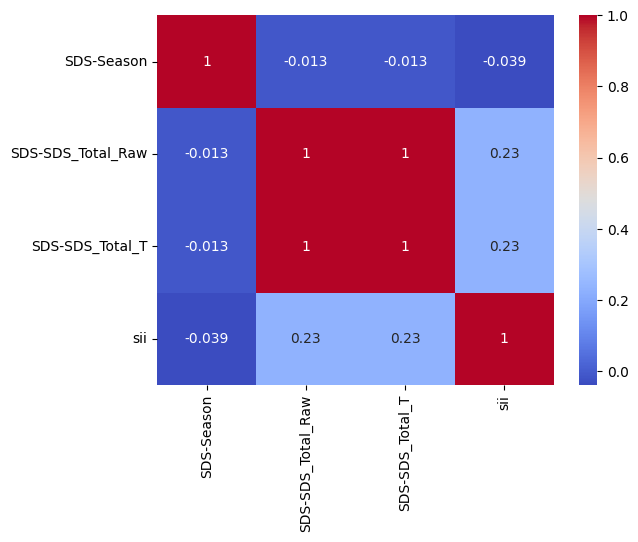

In [630]:
# Checking for Multicollinearity
# Assuming you have a dataframe 'df' with your features
correlation_matrix = sds.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Looks fine, nothing to worry about

In [631]:
sds.drop(['SDS-SDS_Total_Raw'], axis=1, inplace=True)
# Dropping all rows with empty values
sds = sds.dropna()

/var/folders/z8/p6sy93y54_lchr7g5zzh568c0000gn/T/ipykernel_87298/3251898247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sds.drop(['SDS-SDS_Total_Raw'], axis=1, inplace=True)


### Multiclass

In [632]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    sds.drop('sii', axis=1).to_numpy(),
    sds[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1515, 2)
y_train shape (1515, 1)
X_val shape (505, 2)
y_val shape (505, 1)
X_test shape (505, 2)
y_test shape (505, 1)


In [633]:
# Build Model
model = build_model(model="multiclass",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
loss: 1.1350101232528687
W:
 [[1.1507767  1.0263224 ]
 [0.99671763 1.0093713 ]
 [0.8348668  1.0042553 ]
 [0.7381782  0.9723876 ]]


In [634]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
The accuracy is:0.5722772277227722
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 1.0772


1.0686020851135254

### Binary

In [635]:
# Make sii a logistic regression to either refer or not refer a patient
sds['sii'] = sds['sii'].replace(2.0, 1.0)
sds['sii'] = sds['sii'].replace(3.0, 1.0)

In [636]:
# Checking the replace worked
sds["sii"].value_counts()

sii
0.0    1470
1.0    1055
Name: count, dtype: int64

In [637]:
# Run train-test split
# define splits
split = (0.6, 0.2, 0.2)

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    sds.drop('sii', axis=1).to_numpy(),
    sds[["sii"]].to_numpy(),
    split
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (1515, 2)
y_train shape (1515, 1)
X_val shape (505, 2)
y_val shape (505, 1)
X_test shape (505, 2)
y_test shape (505, 1)


In [638]:
# Build Model
model = build_model(model="binary",X_train=X_train, y_train=y_train)

# As above, get predictions for the current model first.
preds = model.predict(X_train)

# Do a single gradient update.
history = model.fit(
  x = X_train,
  y = y_train,
  validation_data=(X_val, y_val),
  epochs=50,
  batch_size=10,
  verbose=0)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


/Users/annamowat/anaconda3/envs/myenvironment/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


predictions:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
loss: 0.7174968123435974
W:
 [[1.0863172  1.0096649 ]
 [0.91367835 0.99033207]]


In [639]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == y_test)
print(f"The accuracy is:{accuracy}")
model.evaluate(x=X_test, y=y_test)

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
The accuracy is:0.5722772277227722
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 0.8425


0.8394010663032532